In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix

### Read in the data from the csv file. 

In [2]:
df = pd.read_csv('wholesale_customers_data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Store the Channel column in a separate variable.

`CHANNEL` is our target.

In [3]:
# Labels: Horeca [1] (Hotel/Restaurant/Cafe) or Retail channel [2] (Nominal)
channel = df['Channel']
channel.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

In [4]:
ACTUAL_NUM_OF_CLUSTERS = len(channel.unique())
ACTUAL_NUM_OF_CLUSTERS

2

### Drop the Region and Channel columns from the dataframe.

In [5]:
data = df.drop(['Channel', 'Region'], axis=1) # these are both labels
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Let's do some K-Means on some Unscaled Data!

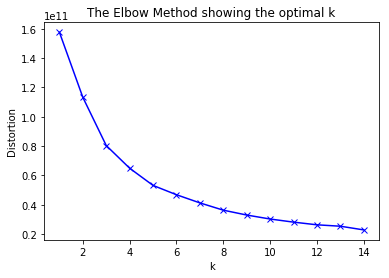

In [6]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sum_of_squared_distances.append(km.inertia_)
    

# Plot the elbow
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Seems inaccurate; biggest jump is between 1.6 and 1.1 at about 2 clusters

In [7]:
# STEP 1: Instantiate our model with best guess as to n_clusters.
kmeans_model = KMeans(n_clusters=ACTUAL_NUM_OF_CLUSTERS)

# STEP 2: Fit our data to our model.
kmeans_model.fit(data) # unscaled data

# STEP 3: Check our model label types.
targets_pred = kmeans_model.labels_

# STEP 4: Run some predictions!
kmeans_model.predict([[13260, 1195, 4220, 6400, 500, 1790]]) # test point w/ true label 0

# STEP 5 (optional): Check the Cluster Centers.
kmeans_model.cluster_centers_

array([[ 7944.112     ,  5151.81866667,  7536.128     ,  2484.13066667,
         2872.55733333,  1214.26133333],
       [35401.36923077,  9514.23076923, 10346.36923077,  6463.09230769,
         2933.04615385,  3316.84615385]])

In [8]:
targets_true = np.array([item - 1 for item in channel]) # map to be same values as results
targets_true

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,

In [9]:
error_counter = 0
for index, item in enumerate(targets_pred):
    if item != targets_true[index]:
        error_counter += 1
        
total_error = 100 * error_counter / len(targets_pred)
        
# this is kash's terrible hacky way of showing correct accuracy vs error
if total_error > 50:
    total_error = 100 - total_error
        
total_error = 100 * error_counter / len(targets_pred)
print("\nTOTAL ERROR IN UNSCALED DATA CLUSTERING PREDICTION IS: {:.2f}%".format(total_error))
print("\nACCURACY OF UNSCALED DATA CLUSTERING MODEL IS: {:.2f}%\n".format(100 - total_error))




TOTAL ERROR IN UNSCALED DATA CLUSTERING PREDICTION IS: 40.68%

ACCURACY OF UNSCALED DATA CLUSTERING MODEL IS: 59.32%



In [10]:
targets_true = np.array([item - 1 for item in channel])
targets_true

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,

In [11]:
def cmat_(cm, labels=None):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="g", ax=ax)
    
    ax.set_title("Confusion Matrix on Unscaled Data")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    
    if labels:
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
    plt.show()

#### Visualize Confusion Matrix

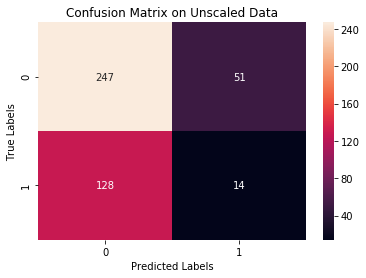

In [12]:
cmat_obj = confusion_matrix(targets_true, targets_pred)
cmat_(cmat_obj)

## Let's Do More K-Means on Scaled Data!

### Scale the data. 

In [13]:
X_scaled = preprocessing.scale(data)
X_scaled

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

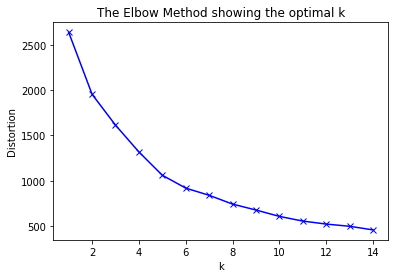

In [14]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    sum_of_squared_distances.append(km.inertia_)
    

    # Plot the elbow
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# A bit better biggest chage in slope is between 2500 and 2000 disortion

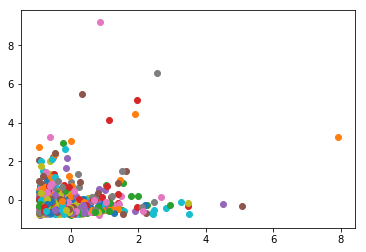

In [15]:
for k, (i,j) in enumerate(zip(X_scaled[:, 0], X_scaled[:, 1])):
    plt.scatter(i, j)
    
plt.show()

# oof!

In [16]:
# STEP 1: Instantiate our model with best guess as to n_clusters.
kmeans_model = KMeans(n_clusters=ACTUAL_NUM_OF_CLUSTERS)

# STEP 2: Fit our data to our model.
kmeans_model.fit(X_scaled) # scaled data

# STEP 3: Check our model label types.
scaled_targets_pred = kmeans_model.labels_

# STEP 4: Run some predictions!
# kmeans_model.predict([[13260, 1195, 4220, 6400, 500, 1790]]) # test point w/ true label 0

# STEP 5 (optional): Check the Cluster Centers.
kmeans_model.cluster_centers_

array([[-0.00689859, -0.19077015, -0.21063944, -0.00533955, -0.21799404,
        -0.07901651],
       [ 0.07982658,  2.20748316,  2.43739927,  0.06178626,  2.52250243,
         0.91433391]])

In [17]:
error_counter = 0
for index, item in enumerate(scaled_targets_pred):
    if item != targets_true[index]:
        error_counter += 1
        
total_error = 100 * error_counter / len(scaled_targets_pred)

# this is kash's terrible hacky way of showing correct accuracy vs error
if total_error > 50:
    total_error = 100 - total_error

print("\nTOTAL ERROR IN SCALED DATA CLUSTERING PREDICTION IS: {:.2f}%".format(total_error))
print("\nACCURACY OF SCALED DATA CLUSTERING MODEL IS: {:.2f}%\n".format(100 - total_error))


TOTAL ERROR IN SCALED DATA CLUSTERING PREDICTION IS: 25.23%

ACCURACY OF SCALED DATA CLUSTERING MODEL IS: 74.77%



In [18]:
def cmat_(cm, labels=None):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="g", ax=ax)
    
    ax.set_title("Confusion Matrix on Scaled Data")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    
    if labels:
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
    plt.show()

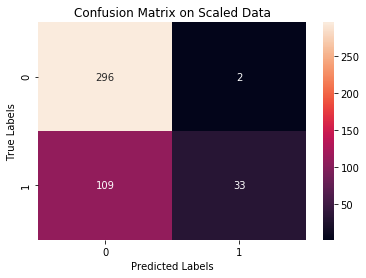

In [19]:
cmat_obj = confusion_matrix(targets_true, scaled_targets_pred)
cmat_(cmat_obj)

## Let's Do One More K-Means, this time with PCA!

### Dimensionality reduction using PCA. 

In [20]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X_scaled)

In [21]:
# print(X_r)
print("Explained variance:", pca.explained_variance_) # forget about this
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Explained variance ratio with cumulative sum:", 
     pca.explained_variance_ratio_.cumsum())

Explained variance: [2.65099857 1.70646229]
Explained variance ratio: [0.44082893 0.283764  ]
Explained variance ratio with cumulative sum: [0.44082893 0.72459292]


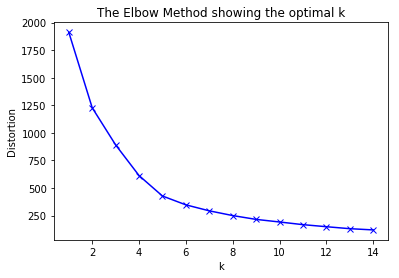

In [22]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_r)
    sum_of_squared_distances.append(km.inertia_)
    

    # Plot the elbow
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Much better! Biggest jump is between ~ 1900 and ~1250 at the 2 clusters mark

### Fit a K-Means object to the data and then visualize the data and the clustering. 

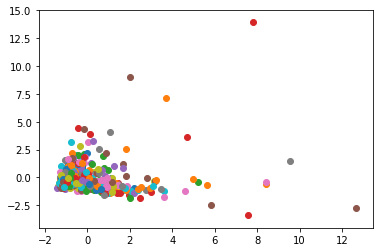

In [23]:
for k, (i,j) in enumerate(zip(X_r[:, 0], X_r[:, 1])):
    plt.scatter(i, j)
    
plt.show()

# not much better 🤔

In [24]:
# km = KMeans(n_clusters=4)
km = KMeans(n_clusters=2)
km.fit(X_r)
print(km.cluster_centers_)

[[ 3.67428358 -0.40751388]
 [-0.41858927  0.04642563]]


## Now for the KMeans!

In [25]:
# STEP 1: Instantiate our model with best guess as to n_clusters.
kmeans_model = KMeans(n_clusters=ACTUAL_NUM_OF_CLUSTERS)

# STEP 2: Fit our data to our model.
kmeans_model.fit(X_r) # PCA fitted data

# STEP 3: Check our model label types.
PCA_targets_pred = kmeans_model.labels_

# STEP 4: Run some predictions!
# kmeans_model.predict([[13260, 1195, 4220, 6400, 500, 1790]]) # test point w/ true label 0

# STEP 5 (optional): Check the Cluster Centers.
kmeans_model.cluster_centers_

array([[ 3.67428358, -0.40751388],
       [-0.41858927,  0.04642563]])

In [26]:
error_counter = 0
for index, item in enumerate(PCA_targets_pred):
    if item != targets_true[index]:
        error_counter += 1

total_error = 100 * error_counter / len(PCA_targets_pred)
# this is kash's terrible hacky way of showing correct accuracy vs error
if total_error > 50:
    total_error = 100 - total_error
        

print("\nTOTAL ERROR IN PCA FITTED DATA CLUSTERING PREDICTION IS: {:.2f}%".format(total_error))
print("\nACCURACY OF PCA FITTED DATA CLUSTERING MODEL IS: {:.2f}%\n".format(100 - total_error))




TOTAL ERROR IN PCA FITTED DATA CLUSTERING PREDICTION IS: 22.95%

ACCURACY OF PCA FITTED DATA CLUSTERING MODEL IS: 77.05%



In [27]:
def cmat_(cm, labels=None):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="g", ax=ax)
    
    ax.set_title("Confusion Matrix on Scaled Data")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    
    if labels:
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
    plt.show()

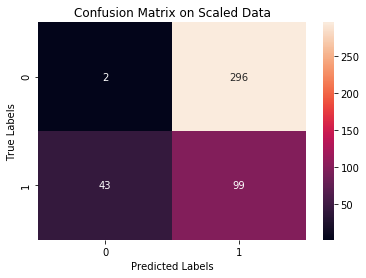

In [28]:
cmat_obj = confusion_matrix(targets_true, PCA_targets_pred)
cmat_(cmat_obj)